<a href="https://colab.research.google.com/github/lukplamino/DADS7202_HW02-CNN_MNLP_Group/blob/main/VGG16_Fine_Tuning_MNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9bc16f90-163f-5414-5871-05649572f3da)


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

The scikit-learn version is 1.0.2
TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [4]:
#Set random seed
np.random.seed(1234)
tf.random.set_seed(5678)

# **Load Data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#0 = Lady_Finger_Banana, 1 = Cavendish_Banana, 2 = Cultivated_Banana 

x0 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Lady_Finger_Banana.npy')
x1 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Cavendish_Banana.npy')
x2 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Cultivated_Banana.npy')

print(x0.shape); print(x1.shape); print(x2.shape)

(200, 224, 224, 3)
(200, 224, 224, 3)
(200, 224, 224, 3)


In [7]:
y0 = np.array([0 for i in range(200)])
y1 = np.array([1 for i in range(200)])
y2 = np.array([2 for i in range(200)])

print(y0.shape); print(y1.shape); print(y2.shape)

(200,)
(200,)
(200,)


In [8]:
x = np.concatenate((x0, x1, x2))
y = np.concatenate((y0, y1, y2))
print(x.shape)
print(y.shape)

(600, 224, 224, 3)
(600,)


In [9]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 3)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(420, 224, 224, 3)
(420,)
(180, 224, 224, 3)
(180,)


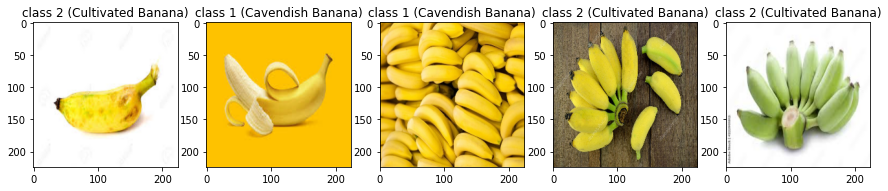

In [10]:
#visualize the first 5 image of x_train
label = ['Lady Finger Banana','Cavendish Banana','Cultivated Banana']
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]} ({label[y_train[i]]})')
  plt.imshow(x_train[i])
plt.show()

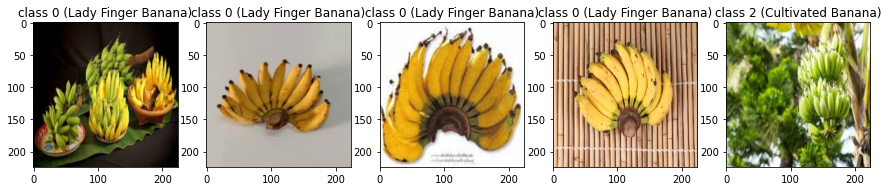

In [11]:
#visualize the first 5 image of x_test
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_test[i])
plt.show()

# **Select Pre-Trained Model**

In [12]:
#Load VGG16 model
x_extractor = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
x_extractor.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [13]:
#Pre-processing
x_train_vgg16 = preprocess_input(x_train)
x_test_vgg16 = preprocess_input(x_test)

print(x_train_vgg16.shape)
print(x_test_vgg16.shape)

(420, 224, 224, 3)
(180, 224, 224, 3)


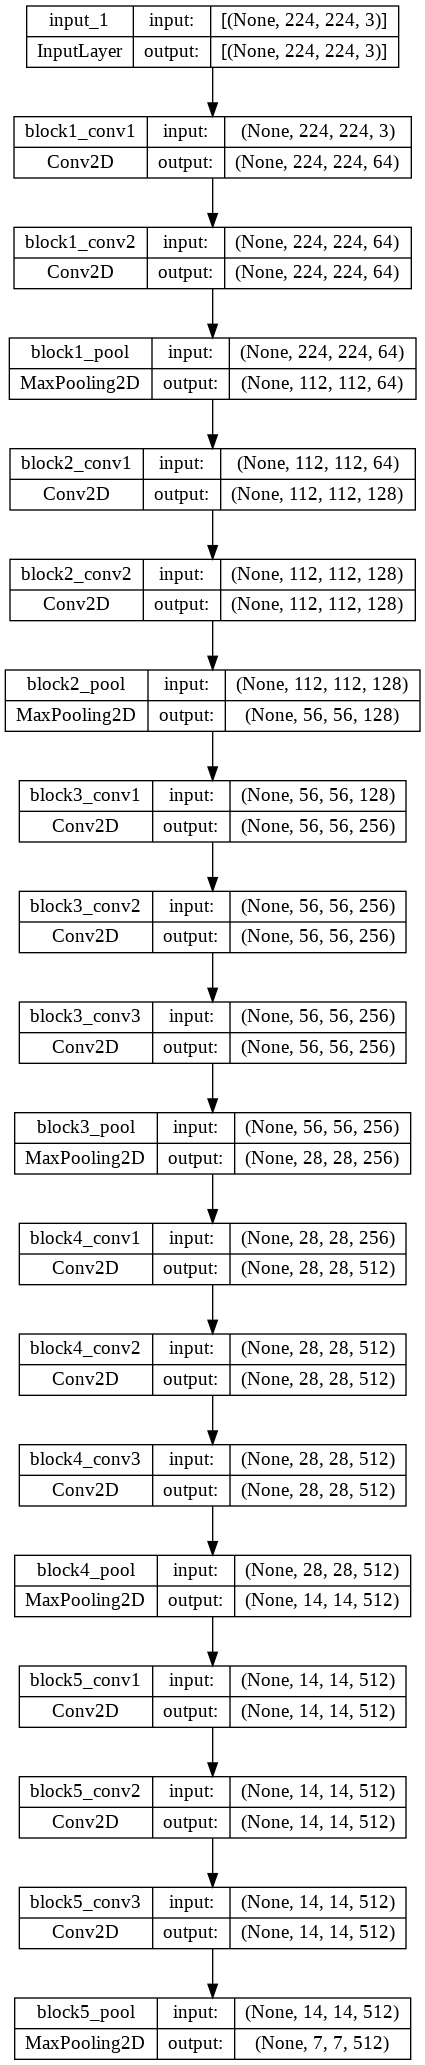

In [14]:
tf.keras.utils.plot_model(x_extractor, to_file = 'VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [15]:
#Recursively freeze all layers in the model first
x_extractor.trainable = False

for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = False
Layer 18: Name = block5_pool, Trainable = False


In [16]:
# Access a layer by 0-based index
# a = x_extractor.layers[16,17]
# a.trainable = True
#print(f'Layer {a}: Name = {a.name}, Trainable = {a.trainable}')
# for i in a:
#   i.trainable=True

#Access a layer by name
b = x_extractor.get_layer('block5_conv3')
# c = x_extractor.get_layer('block5_conv2')
# d = x_extractor.get_layer('block5_conv1')
# e = x_extractor.get_layer('block4_conv3')
print(f'Layer {b}: Name = {b.name}, Trainable = {b.trainable}')

b.trainable=True
# c.trainable=True
# d.trainable=True
# e.trainable=True

Layer <keras.layers.convolutional.conv2d.Conv2D object at 0x7fcb9e296d50>: Name = block5_conv3, Trainable = False


##Fine-tuning by unfreezing Layer 17

In [17]:
#Iterate over all layers in the model
for i, layer in enumerate(x_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = True
Layer 18: Name = block5_pool, Trainable = False


# **Data Augmentation**

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,             
        samplewise_center=True,             
        #featurewise_std_normalization=True,  
        samplewise_std_normalization=True,   
        #zca_whitening=False,                  
        rotation_range=0,                     
        width_shift_range=5.0,                
        height_shift_range=5.0,               
        zoom_range=0.2,
        horizontal_flip=True,                 
        vertical_flip=True,
        validation_split=0.3)
train_datagen.fit(x_train_vgg16)

In [19]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        # featurewise_center=True,             
        samplewise_center=True,             
        # featurewise_std_normalization=True,  
        samplewise_std_normalization=True
        )
test_datagen.fit(x_test_vgg16)

===== Train batch no. 1/1 =====


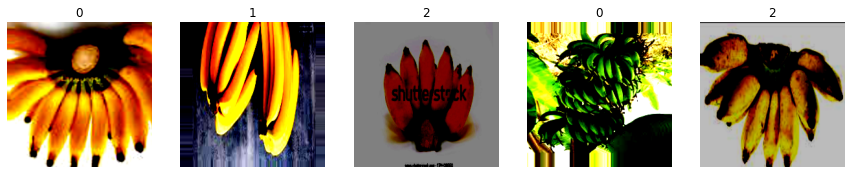

In [20]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


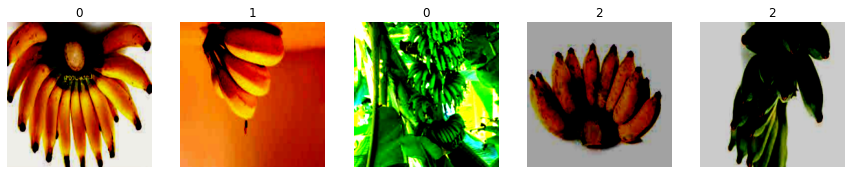

In [21]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


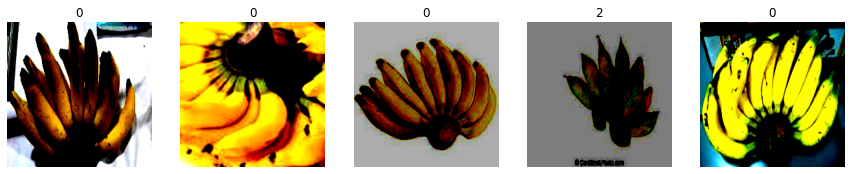

In [22]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( test_datagen.flow( x_test,y_test,batch_size=5 ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

# **Train & Model Evaluate**

In [23]:
x = x_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)

x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = x_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc'] 
                     )

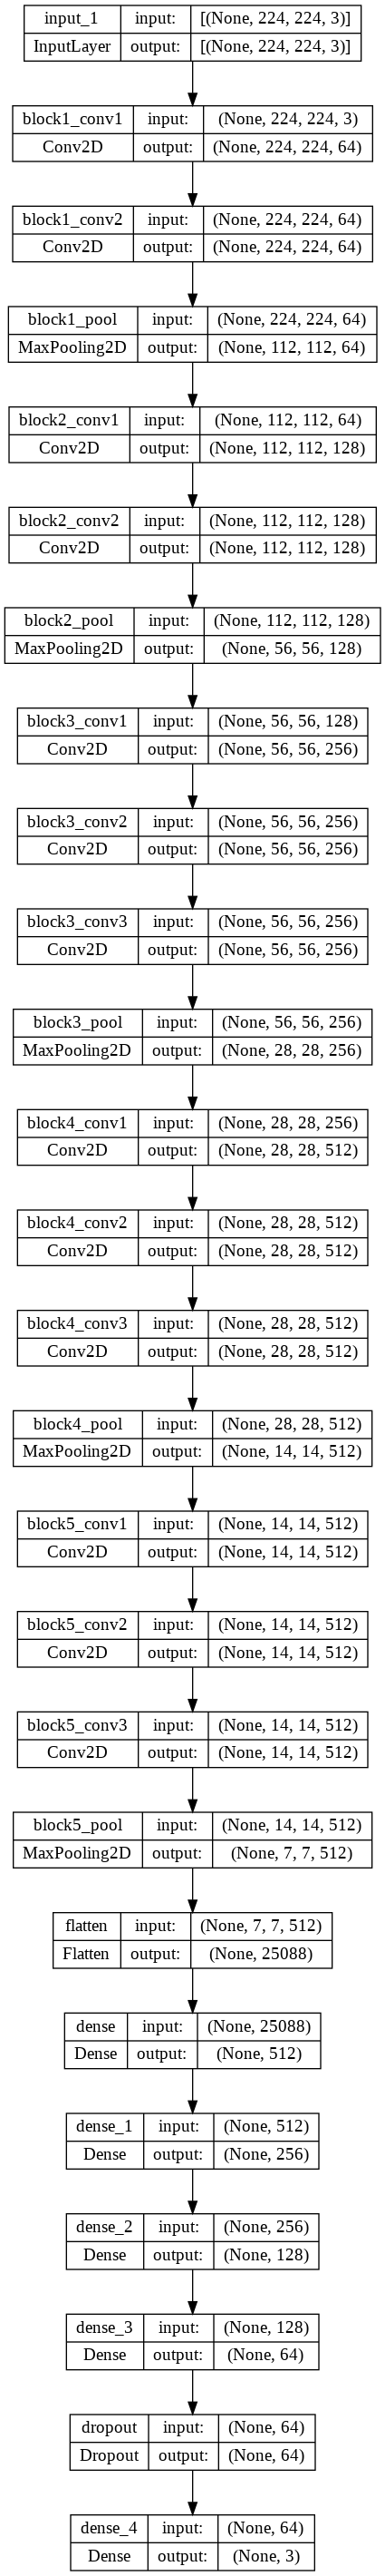

In [25]:
tf.keras.utils.plot_model(model, to_file = 'VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [26]:
history = model.fit(train_datagen.flow(x_train_vgg16 ,y_train,batch_size=32,subset='training'),epochs = 30, verbose = 2,
                    validation_data=train_datagen.flow(x_train_vgg16 ,y_train,batch_size=32,subset='validation'))

Epoch 1/30
10/10 - 21s - loss: 1.5145 - acc: 0.4388 - val_loss: 0.8375 - val_acc: 0.6587 - 21s/epoch - 2s/step
Epoch 2/30
10/10 - 5s - loss: 0.7618 - acc: 0.6837 - val_loss: 0.3758 - val_acc: 0.8571 - 5s/epoch - 480ms/step
Epoch 3/30
10/10 - 6s - loss: 0.5805 - acc: 0.7687 - val_loss: 0.3401 - val_acc: 0.8730 - 6s/epoch - 639ms/step
Epoch 4/30
10/10 - 5s - loss: 0.4262 - acc: 0.8299 - val_loss: 0.6171 - val_acc: 0.7143 - 5s/epoch - 511ms/step
Epoch 5/30
10/10 - 5s - loss: 0.4387 - acc: 0.8299 - val_loss: 0.3142 - val_acc: 0.8810 - 5s/epoch - 489ms/step
Epoch 6/30
10/10 - 5s - loss: 0.3145 - acc: 0.8946 - val_loss: 0.4135 - val_acc: 0.8889 - 5s/epoch - 484ms/step
Epoch 7/30
10/10 - 5s - loss: 0.3131 - acc: 0.9116 - val_loss: 0.3935 - val_acc: 0.8810 - 5s/epoch - 491ms/step
Epoch 8/30
10/10 - 5s - loss: 0.2492 - acc: 0.9320 - val_loss: 0.2524 - val_acc: 0.8889 - 5s/epoch - 482ms/step
Epoch 9/30
10/10 - 5s - loss: 0.1601 - acc: 0.9456 - val_loss: 0.2821 - val_acc: 0.9286 - 5s/epoch - 483m

In [27]:
results = model.evaluate(test_datagen.flow(x_test_vgg16, y_test, batch_size = 128))
print(f'{model.metrics_names}: {results}')

2/2 [==============================] - 16s 4s/step - loss: 0.4287 - acc: 0.9056
['loss', 'acc']: [0.428655743598938, 0.9055555462837219]


In [ ]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

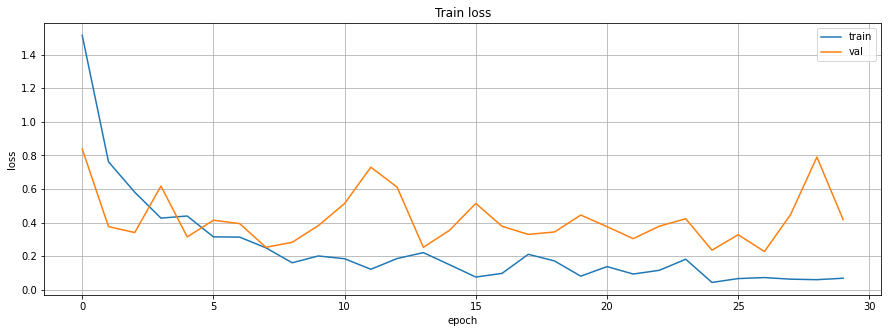

In [29]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

1/1 [==============================] - 0s 16ms/step


[Text(32.99999999999999, 0.5, 'Actual'), Text(0.5, 15.0, 'Predict')]

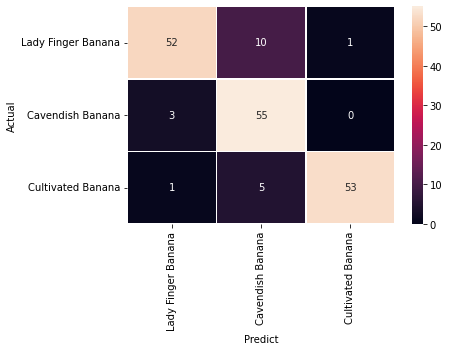

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = []
for i in range(len(x_test_vgg16)):
  x_input = x_test_vgg16[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')

In [31]:
# for i in range(len(x_test_vgg16)):
#   y_pred = model.predict(x_test_vgg16[i].reshape(1,224,224,3))
#   if np.argmax(y_pred) != y_test[i] and y_test[i]==1:
#     plt.imshow(x_test[i])
#     plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
#     plt.show()
#   else:
#     continue

1/1 [==============================] - 0s 22ms/step


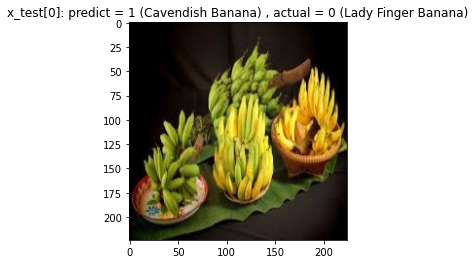

1/1 [==============================] - 0s 22ms/step


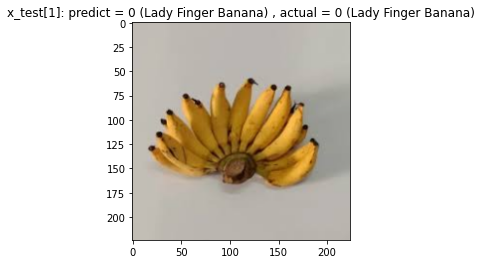

1/1 [==============================] - 0s 25ms/step


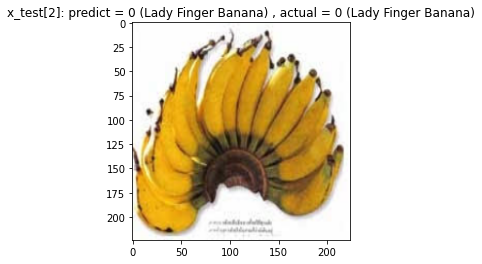

1/1 [==============================] - 0s 24ms/step


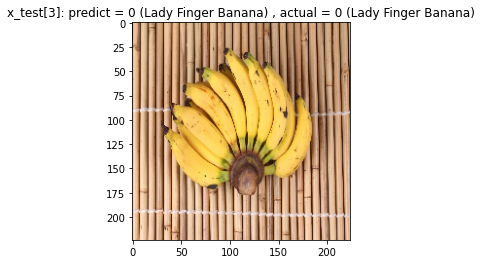

1/1 [==============================] - 0s 26ms/step


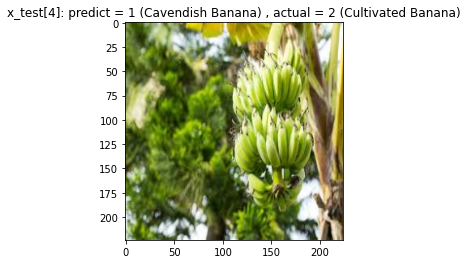

In [32]:
for i in range(5):
  y_pred = model.predict(x_test_vgg16[i].reshape(1,224,224,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# **Grad-CAM**

In [ ]:
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

1/1 [==============================] - 0s 27ms/step
Predicted: Cavendish Banana | Actual: Cavendish Banana 


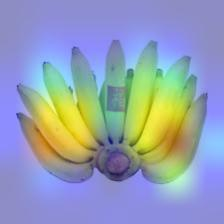

1/1 [==============================] - 0s 16ms/step
Predicted: Cavendish Banana | Actual: Cavendish Banana 


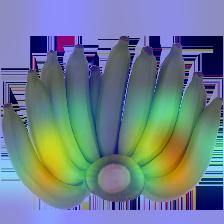

1/1 [==============================] - 0s 19ms/step
Predicted: Lady Finger Banana | Actual: Lady Finger Banana 


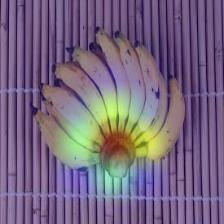

1/1 [==============================] - 0s 20ms/step
Predicted: Lady Finger Banana | Actual: Lady Finger Banana 


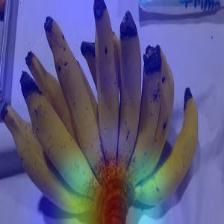

1/1 [==============================] - 0s 20ms/step
Predicted: Cavendish Banana | Actual: Cavendish Banana 


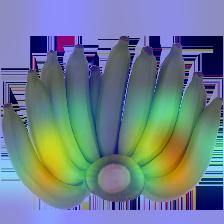

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c= np.random.randint(0,180)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)